In [2]:
# 1. Các thư viện cần thiết
!pip3 install -U git+https://github.com/PYFTS/pyFTS
import pandas as pd
import numpy as np
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.models import chen
from pyFTS.common import FLR
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Fix the import in the pyFTS library if necessary
# In the file '/usr/local/lib/python3.10/dist-packages/pyFTS/common/transformations/trend.py', change:
# from pandas import datetime
# to:
# from pandas import Timestamp

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-xudmekk8
  Running command git clone --filter=blob:none --quiet https://github.com/PYFTS/pyFTS /tmp/pip-req-build-xudmekk8
  Resolved https://github.com/PYFTS/pyFTS to commit 4e0ee7cdd9fc9a8ac9170c0c3496536ef0378cb7
  Preparing metadata (setup.py) ... done


# **Chia train test validate theo tỉ lệ 8:1:1**

In [27]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('BNB.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [28]:
# 3. Chia train test validate theo tỉ lệ 8:1:1
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


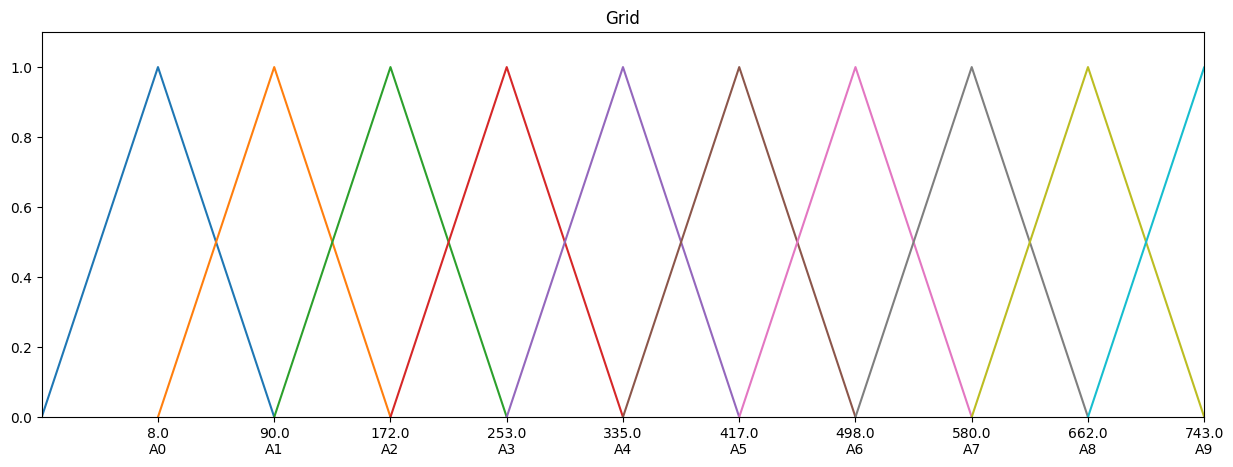

In [29]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=10)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [30]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [31]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A2 -> A4', 'A3 -> A3', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A3 -> A2', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A4', 'A5 -> A5', 'A5 -> A3', 'A4 -> A6', 'A5 -> A6', 'A6 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A6 -> A8', 'A7 -> A7', 'A7 -> A8', 'A7 -> A6', 'A8 -> A6', 'A8 -> A7', 'A7 -> A5', 'A8 -> A8', 'A7 -> A9', 'A8 -> A9', 'A9 -> A7', 'A9 -> A8', 'A6 -> A4', 'A7 -> A4']


In [32]:
# 7. Xây dựng mô hình FTS
model = chen.ConventionalFTS(partitioner=partitioner)
model.fit(train_data)
print(model)

Conventional FTS:
A0 -> A0,A1
A1 -> A1,A2
A2 -> A1,A2,A3,A4
A3 -> A2,A3,A4
A4 -> A3,A4,A5
A5 -> A4,A5,A6
A6 -> A4,A5,A6,A7
A7 -> A6,A7,A8
A8 -> A7,A8



In [33]:
# 8. Dự đoán dữ liệu test, val
y_pred_test = model.predict(test_data)
y_pred_val = model.predict(val_data)

In [34]:
# 10. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

val_mae = mean_absolute_error(y_pred_val, val_data)
val_rmse = np.sqrt(mean_squared_error(y_pred_val, val_data))
val_mape = mean_absolute_percentage_error(y_pred_val, val_data)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 18.917805157284665
Testing RMSE: 22.603105942519534
Testing MAPE: 0.07102328728889239
Validation MAE: 19.558928423891096
Validation RMSE: 24.09395843463917
Validation MAPE: 0.05306405935864177


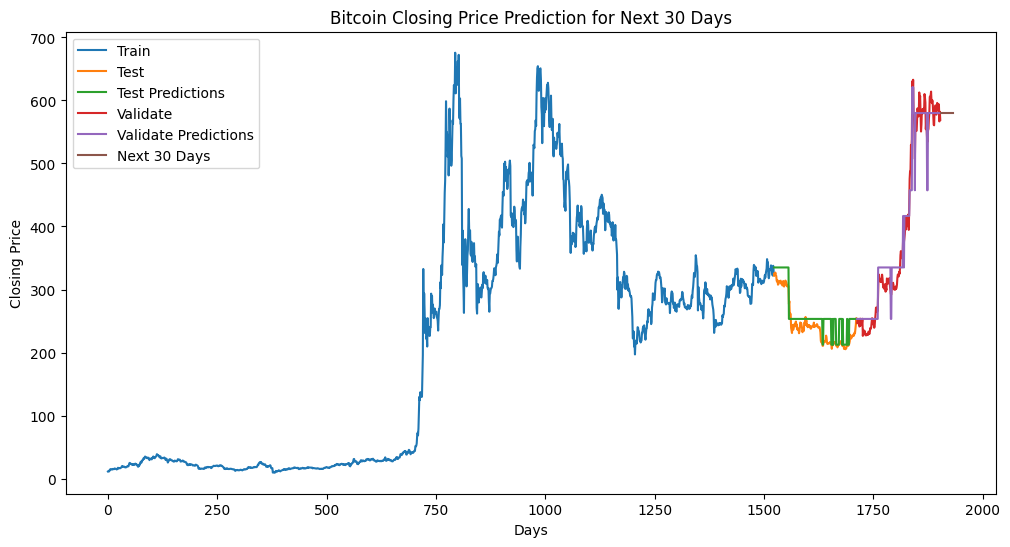

Predicted closing prices for the next 30 days:
[579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802]


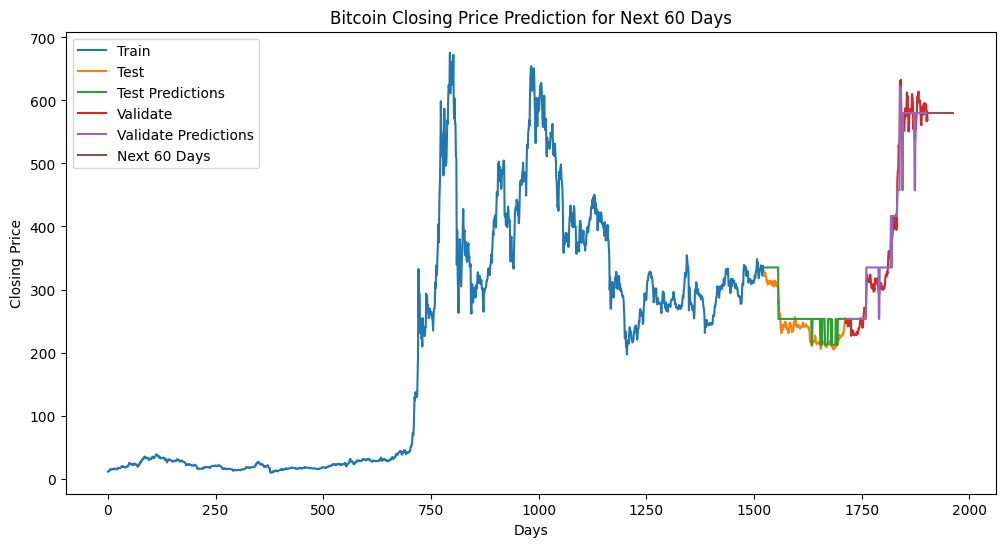

Predicted closing prices for the next 60 days:
[579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802]


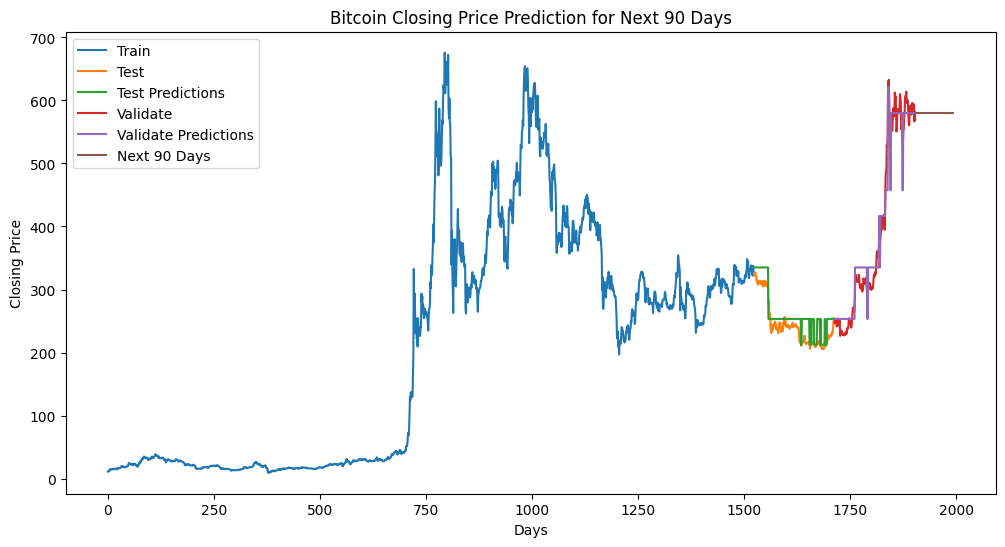

Predicted closing prices for the next 90 days:
[579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579

In [35]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
time_step = 100
def predict_future(model, data, days):
    temp_input = list(data)
    lst_output = []

    for _ in range(days):
        x_input = temp_input[-1]  # Lấy giá trị cuối cùng để dự đoán tiếp
        yhat = model.predict([x_input])[0]  # Dự đoán giá trị tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, days)


    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), val_data, label='Validate')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **Chia train test validate theo tỉ lệ 7:2:1**

In [36]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('BNB.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [37]:
# 3. Chia train test validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


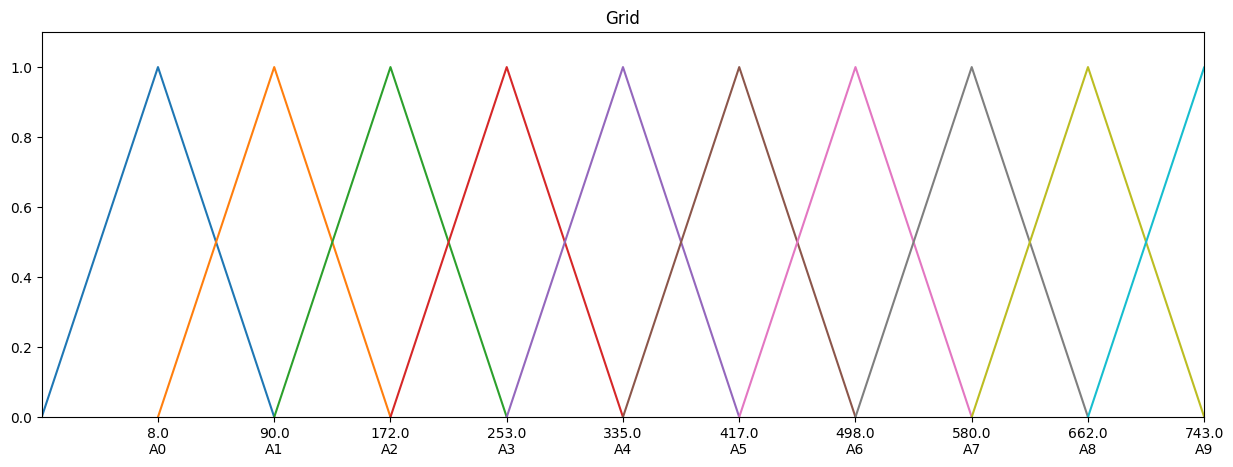

In [38]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=10)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [39]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [40]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A2 -> A4', 'A3 -> A3', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A3 -> A2', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A4', 'A5 -> A5', 'A5 -> A3', 'A4 -> A6', 'A5 -> A6', 'A6 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A6 -> A8', 'A7 -> A7', 'A7 -> A8', 'A7 -> A6', 'A8 -> A6', 'A8 -> A7', 'A7 -> A5', 'A8 -> A8', 'A7 -> A9', 'A8 -> A9', 'A9 -> A7', 'A9 -> A8', 'A6 -> A4', 'A7 -> A4']


In [41]:
# 7. Xây dựng mô hình FTS
model = chen.ConventionalFTS(partitioner=partitioner)
model.fit(train_data)
print(model)

Conventional FTS:
A0 -> A0,A1
A1 -> A1,A2
A2 -> A1,A2,A3,A4
A3 -> A2,A3,A4
A4 -> A3,A4,A5
A5 -> A4,A5,A6
A6 -> A4,A5,A6,A7
A7 -> A6,A7,A8
A8 -> A7,A8



In [43]:
# 8. Dự đoán dữ liệu test, val
y_pred_test = model.predict(test_data)
y_pred_val = model.predict(val_data)

In [44]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

val_mae = mean_absolute_error(y_pred_val, val_data)
val_rmse = np.sqrt(mean_squared_error(y_pred_val, val_data))
val_mape = mean_absolute_percentage_error(y_pred_val, val_data)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 19.620437038229696
Testing RMSE: 23.04839065937556
Testing MAPE: 0.06986915311047527
Validation MAE: 19.49345049460555
Validation RMSE: 24.036421756162063
Validation MAPE: 0.052931306814688626


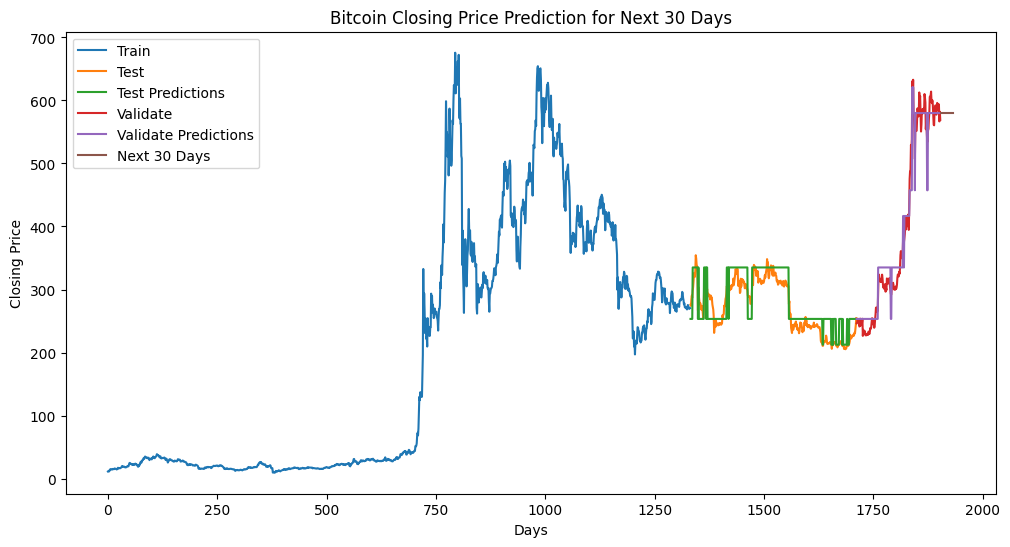

Predicted closing prices for the next 30 days:
[579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802]


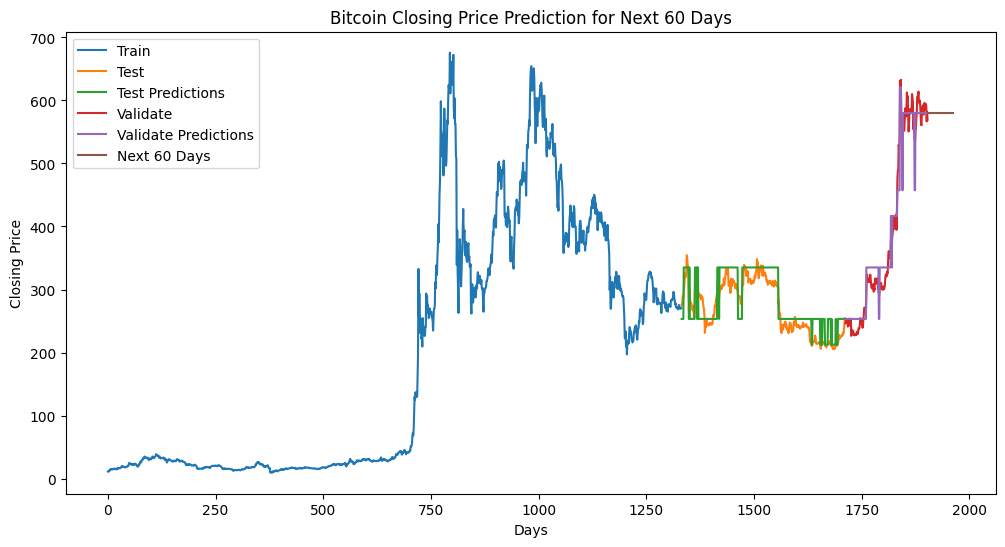

Predicted closing prices for the next 60 days:
[579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802]


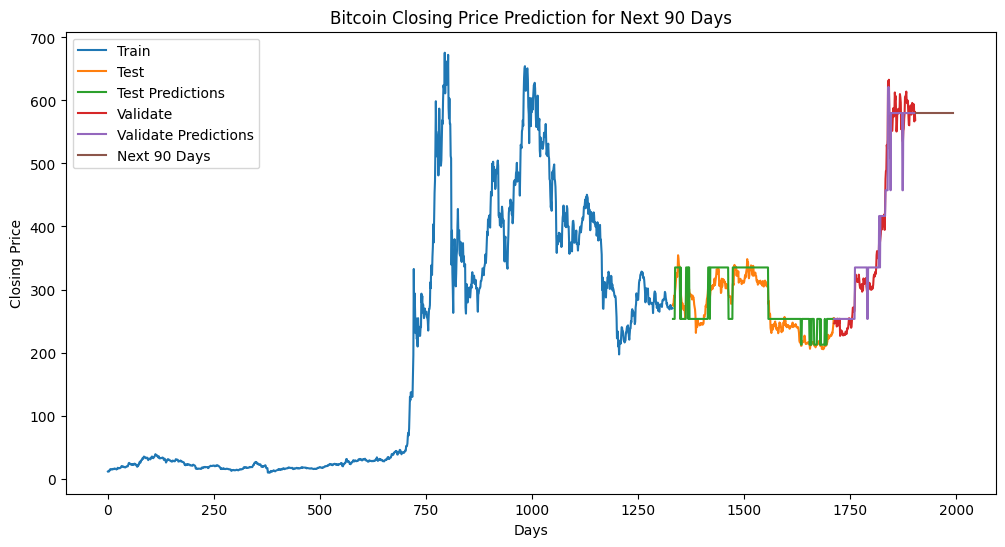

Predicted closing prices for the next 90 days:
[579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579

In [45]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
time_step = 100
def predict_future(model, data, days):
    temp_input = list(data)
    lst_output = []

    for _ in range(days):
        x_input = temp_input[-1]  # Lấy giá trị cuối cùng để dự đoán tiếp
        yhat = model.predict([x_input])[0]  # Dự đoán giá trị tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, days)


    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), val_data, label='Validate')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **Chia train test validate theo tỉ lệ 6:2:2**

In [63]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('BNB.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [64]:
# 3. Chia train test validate theo tỉ lệ 6:2:2
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


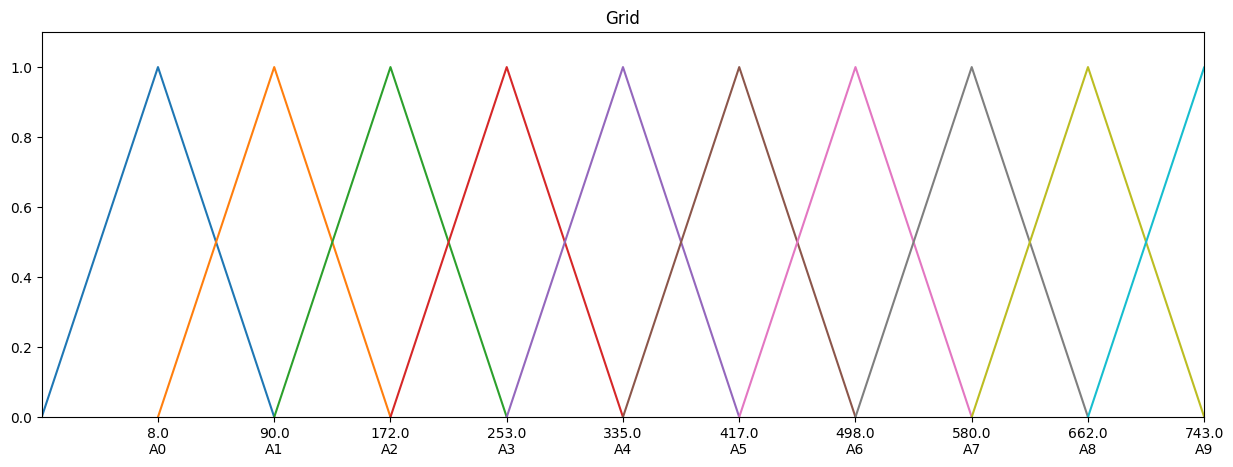

In [65]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=10)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [66]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [67]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A2 -> A4', 'A3 -> A3', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A3 -> A2', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A4', 'A5 -> A5', 'A5 -> A3', 'A4 -> A6', 'A5 -> A6', 'A6 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A6 -> A8', 'A7 -> A7', 'A7 -> A8', 'A7 -> A6', 'A8 -> A6', 'A8 -> A7', 'A7 -> A5', 'A8 -> A8', 'A7 -> A9', 'A8 -> A9', 'A9 -> A7', 'A9 -> A8', 'A6 -> A4', 'A7 -> A4']


In [68]:
# 7. Xây dựng mô hình FTS
model = chen.ConventionalFTS(partitioner=partitioner)
model.fit(train_data)
print(model)

Conventional FTS:
A0 -> A0,A1
A1 -> A1,A2
A2 -> A1,A2,A3,A4
A3 -> A2,A3,A4
A4 -> A3,A4,A5
A5 -> A4,A5,A6
A6 -> A4,A5,A6,A7
A7 -> A6,A7,A8
A8 -> A7,A8



In [69]:
# 8. Dự đoán dữ liệu test, val
y_pred_test = model.predict(test_data)
y_pred_val = model.predict(val_data)

In [70]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

val_mae = mean_absolute_error(y_pred_val, val_data)
val_rmse = np.sqrt(mean_squared_error(y_pred_val, val_data))
val_mape = mean_absolute_percentage_error(y_pred_val, val_data)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 21.741085553283263
Testing RMSE: 24.432131036999678
Testing MAPE: 0.0752471232603803
Validation MAE: 19.20534440169679
Validation RMSE: 23.334013540064802
Validation MAPE: 0.061907000155251496


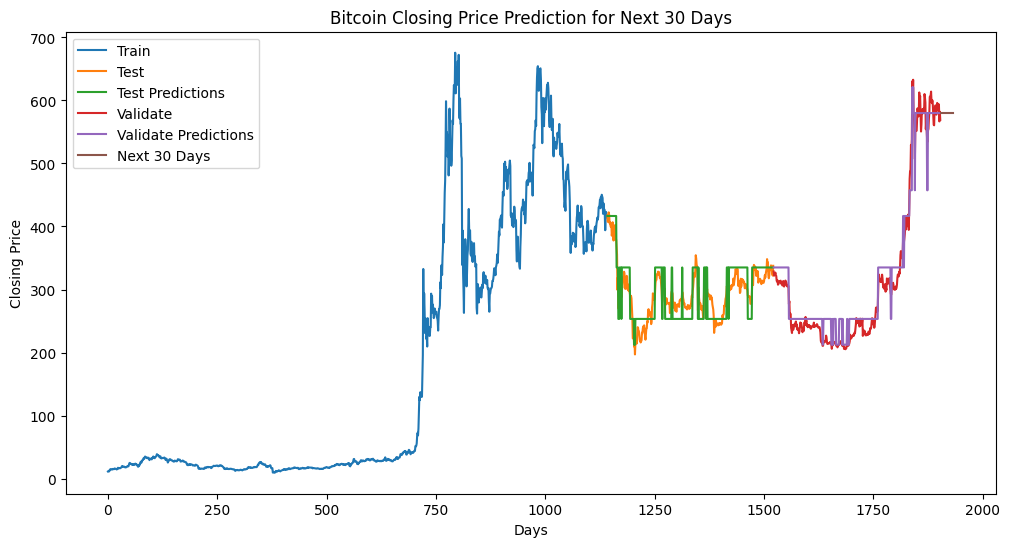

Predicted closing prices for the next 30 days:
[579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802]


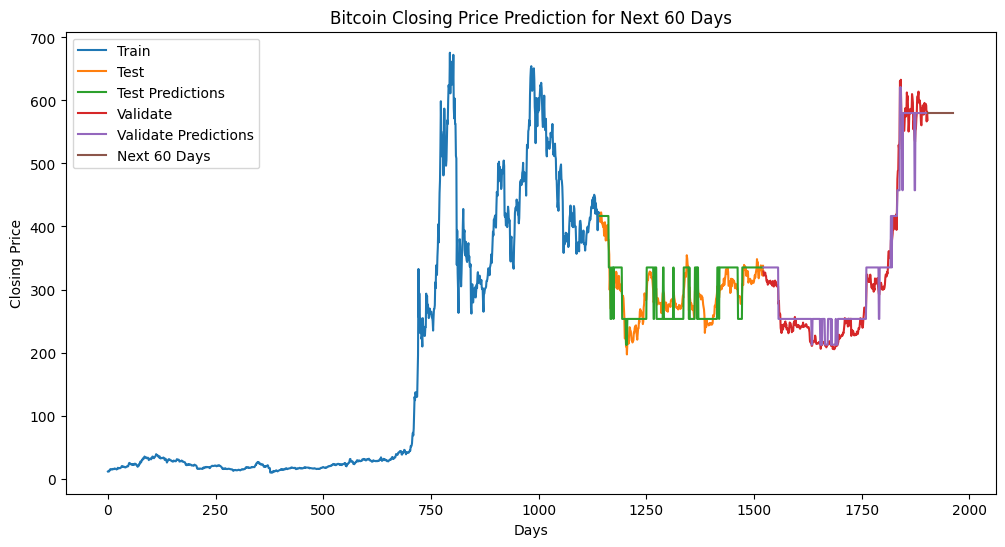

Predicted closing prices for the next 60 days:
[579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802]


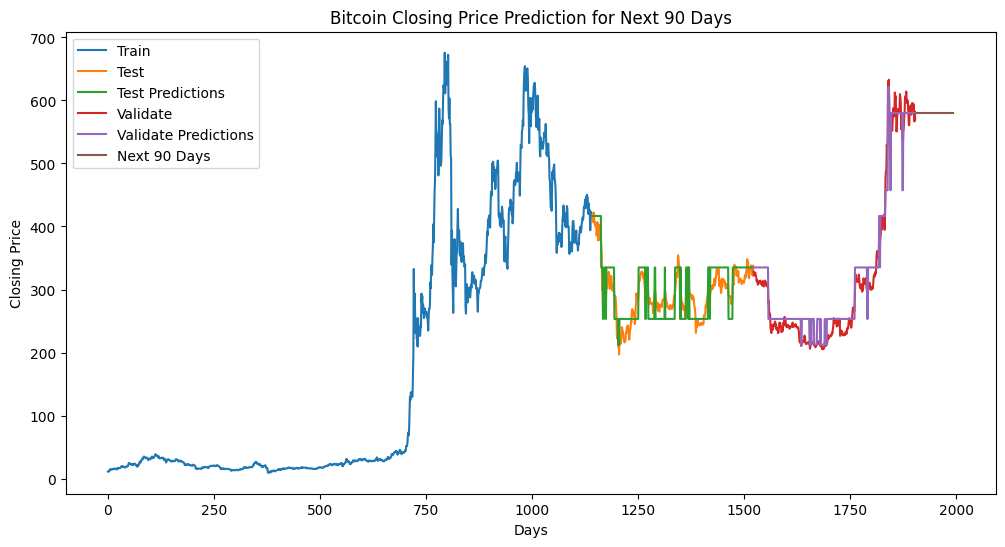

Predicted closing prices for the next 90 days:
[579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802 579.9624802
 579

In [71]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
time_step = 100
def predict_future(model, data, days):
    temp_input = list(data)
    lst_output = []

    for _ in range(days):
        x_input = temp_input[-1]  # Lấy giá trị cuối cùng để dự đoán tiếp
        yhat = model.predict([x_input])[0]  # Dự đoán giá trị tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, days)


    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), val_data, label='Validate')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())